### Tutorial Notebook Showing How sus, infoenginessims work together to make a sim object

In [1]:
#standard imports, these can be done automatically using a conda environemnt
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# imports to deal with getting nice animations and outputs for matplotlip in jupyter
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline



In [2]:
# I always keep my code in a folder in my home directory called 'source/', and begin with the following:
source_path = os.path.expanduser('~/Project/source/')
sys.path.append(source_path)
# which will enable the following imports:
from sus import protocol_designer as pd
from sus.library.szilard_protocols import blw_szilard

# usually these would not be imported but handled in a separate document, but to show the inner workings 
# of the simtools package, I will manually import some stuff

sim_path = os.path.dirname(source_path + "simtools/infoenginessims/")
sys.path.append(sim_path)

from integrators import rkdeterm_eulerstoch
from dynamics import langevin_underdamped, langevin_overdamped
from simprocedures import basic_simprocedures as sp
from simprocedures import running_measurements as rp
from simulation import Simulation

In [3]:
# first, we have our system, as explained in the sus package tutorial:
system = blw_szilard
init_state = system.eq_state(10_000, 0, beta=1)

#Now, we set up a sim object, to simulate an equation of motion for the system, with the given protocol and 
#time dependent potential

#FIRST, we choose a dynamic. These cam be built, but we have some built in already for langevin dynamics. 
#Let's go for the full underdamped EOM. For more info look inside the docstrings in the simtools package

gamma, theta, eta = 1, 1, 1

#underdamped langevin dynamics takes 3 parameters and the time dependent force function for our system
dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, system.get_external_force)

#it also needs an inertial parameter, the mass. By default all systems have an object mass of 1, but it can 
# be changed
dynamic.mass = system.mass

 found 10149 samples out of 10000

In [4]:
integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

In [5]:
procedures = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=slice(0, 300)),
            rp.MeasureAllValue(rp.get_dW, 'all_W'), 
            rp.MeasureFinalValue(rp.get_dW, 'final_W')]


In [6]:
# Finally, we decide what dt we are going to use:
dt = .0005
nsteps = int(system.protocol.t_f/dt)
# and create a Simulation object
sim = Simulation(integrator.update_state, procedures, nsteps, dt, initial_state=init_state)

# and associate the system with it, for future reference
sim.system = system


In [7]:
#Now this is all set up, we can run a simulation:
sim.output = sim.run(verbose=True)

 step 2000 of 2000 complete

In [10]:
import kyle_tools as kt
all_state = sim.output.all_state['states']
final_state = sim.output.final_state
final_W = sim.output.final_W
all_W = sim.output.all_W


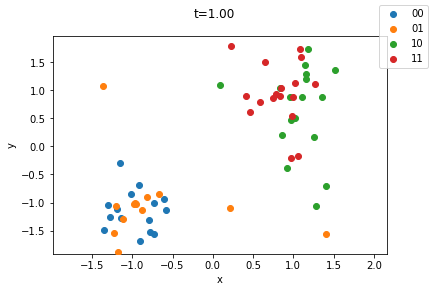

In [11]:
ani,_,_ = kt.animate_sim(all_state, frame_skip=10, color_by_state=True)

HTML(ani.to_jshtml(fps=30))

In [165]:
from numpy import exp as exp

def exp_well_pot(x, y, params):
    '''
    2D potential, an exponential well centered at (0,0)
    with a variable aspect ratio
    
    Parameters
    ----------
    x,y : ndarray of dimension [N_coord,]
        these are lists of the x and y values where we want to find the potential
    params: list [a,b,T]
        a,b : the scale at which the x and y directions change the value of the potential
        T : the overall 'temperature' scale: affects both x and y directions equally
        
    Returns
    -------
    the value of the potential at locations x,y with the given params
    '''
    a, b, T = params
    return(-exp(-(a*x**2+b*y**2)/T))

def exp_well_force(x, y, params):
    '''
    See the exp_well_pot function, it has the same input format
    '''
    a, b, T = params
    dx= 2*a*x*exp(-(a*x**2+b*y**2)/T)/T
    dy= 2*a*y*exp(-(a*x**2+b*y**2)/T)/T
    return(-dx,-dy)
   

In [166]:
exp_well = Potential(exp_well_pot,exp_well_force,3,2)  

# Generally,  we want make a protocol that will operate on the potential. 
# This protocol will go from t=0 to t=.6
t=[0,.6]
#we'll interpolate from a totally symmetric well (a=1,b=1,T=1) to a deformed well at the same T (a=.5,b=2,T=1) 
params=[[1,100],[1, 2],[1,1]]

#now, we make a protocol. WSP is short for well_stetch_protocol
WSP=Protocol(t,params)
well_stretch=System(WSP,exp_well)

WSP_rev=WSP.copy()
WSP_rev.reverse()
WSP_rev.time_shift(WSP.t_f)

SAR_prot=Compound_Protocol((WSP_rev,WSP))
SAR_prot.show_substage_times()

stretch_and_rev=System(SAR_prot,exp_well)

stage 1 times: [0.  0.6]
stage 2 times: [0.6 1.2]


stage 1 times: [0.  0.6]
stage 2 times: [0.6 1.2]


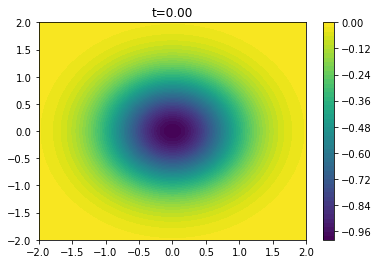

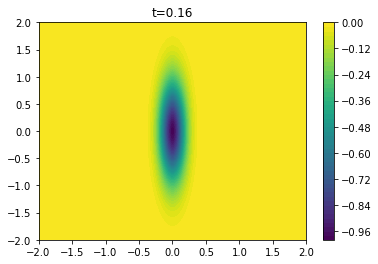

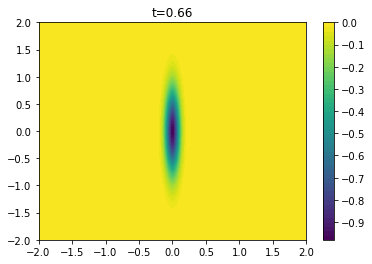

(<AxesSubplot:title={'center':'t=0.66'}>,
 <matplotlib.contour.QuadContourSet at 0x7ff1f102e550>)

In [109]:
# The system we chose is a 2D potential that uses frou wells to implement a Szilard Cycle over 6 substages
stretch_and_rev.protocol.show_substage_times()
# Here are smoe snapshots of the potential
stretch_and_rev.show_potential(0)
stretch_and_rev.show_potential(.16)
stretch_and_rev.show_potential(.66)


In [110]:
%%capture
# and an animation of the whole thing. (Note there are some qorkarounds here ot get animations working in 
# jupyter noteobok. This is one of the weaker parts of the package, but its just for prototyping so I dont 
# worry about it too much).
ani = stretch_and_rev.animate_protocol()
HTML(ani.to_jshtml(fps=30))

In [111]:
ani

In [112]:
# next, we want to generate a starting distribution. Generally its an EQ dist at a certain time (the starting 
# time, here). We take a sample of 10_000 initial conditions from the eq distribution

init_state = stretch_and_rev.eq_state(10_000, 0, beta=1)




 found 10003 samples out of 10000

In [113]:
#the phase space is 2X2 because its a 2D potential and we have 10_000 trials so the shape is...
print(init_state.shape)


(10000, 2, 2)


Text(0.5, 0, 'v_y')

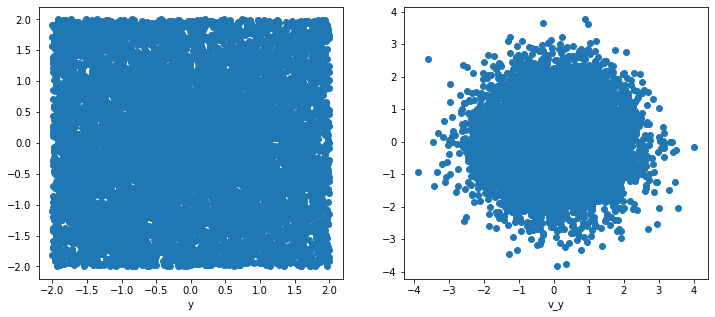

In [114]:
#scatter plot briefly can confirm we have the right dist. 
fig, ax = plt.subplots(1,2, figsize=(12,5))
"""What are the meaning of the indices in the array?"""
ax[0].scatter(init_state[:,0,0], init_state[:,1,0])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')

ax[1].scatter(init_state[:,0,1], init_state[:,1,1])
ax[1].set_xlabel('v_x')
ax[1].set_xlabel('v_y')

In [115]:
#Now, we set up a sim object, to simulate an equation of motion for the system, with the given protocol and 
#time dependent potential
gamma, theta, eta = 1, 1, 1
dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, stretch_and_rev.get_external_force)
dynamic.mass = stretch_and_rev.mass

In [116]:
# SECOND, we need an integrator to integrate the dynamic. Here the integrator is very simple, RK4 for the 
# deterministic part and Euler for the stochastic. This is a place where we could optimize for more intelligent 
# integrators for sure, but they mostly get the job done as is. Again, check the relevant docstrings for more 
# info.

integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)



In [117]:
# Third, we set up procedues to be done. They can happen before the simualtion, throughout it, or at the end. 
# Check relevant docsrings inside of simtools for more info
# from simprocedures import basic_simprocedures as sp
# from simprocedures import running_measurements as rp
# get_dW = get the differential work


procedures = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=slice(0, 300)),
            rp.MeasureAllValue(rp.get_dW, 'all_W'), 
            rp.MeasureFinalValue(rp.get_dW, 'final_W')]

# These four procedures do exactly what it sounds like they would do. The first will give us just the final state
# for all trials. The second measures the whole simulation for the first 100 trials. The third measures work over
# time, and the last gives us the next work for the whole protocol.

In [118]:
# Finally, we decide what dt we are going to use:
dt = .0005
nsteps = int(stretch_and_rev.protocol.t_f/dt)
# and create a Simulation object
sim = Simulation(integrator.update_state, procedures, nsteps, dt, initial_state=init_state)

# and associate the system with it, for future reference
sim.system = stretch_and_rev


In [119]:
#Now this is all set up, we can run a simulation:
sim.output = sim.run(verbose=True)

 step 2400 of 2400 complete

In [120]:
#extract the results for viewing. The sim.output Bunch object acts a lot like a container for dictionaries 
# and numpy arrays that are callable as attributes
all_state = sim.output.all_state['states']
final_state = sim.output.final_state
final_W = sim.output.final_W
all_W = sim.output.all_W


In [121]:
#all the outputs are numpy arrays
print(all_W.shape,':trials, steps')

print(all_state.shape,':trials, steps, dimensions, attributes per dimension')

(10000, 2401) :trials, steps
(300, 2401, 2, 2) :trials, steps, dimensions, attributes per dimension


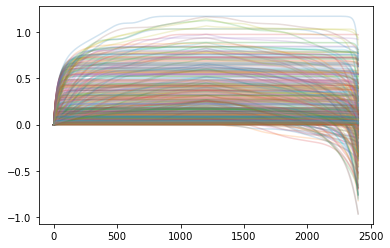

In [122]:
#work over time for the first 500 trials
plt.plot(all_W[:500,:].transpose(), alpha=.2);

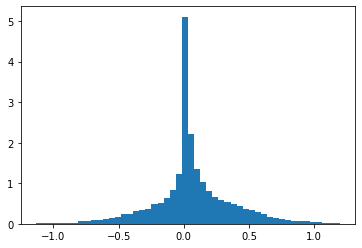

In [123]:
#just net work for all trials:
plt.hist(final_W, bins=50, density=True);

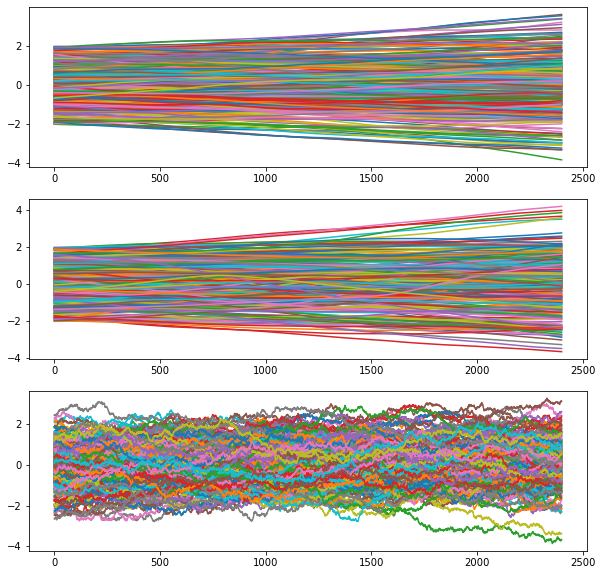

In [124]:
fig,ax = plt.subplots(3, figsize=(10,10))
#here are x,v and v_x plots over time
"""What is v_x plot?"""
ax[0].plot(all_state[:,:,0,0].transpose());
ax[1].plot(all_state[:,:,1,0].transpose());
ax[2].plot(all_state[:,:,0,1].transpose());


In [125]:
import kyle_tools as kt

In [126]:
%%capture
# we can even see an animation of the trajectories where we saved every step. Here the slice is [:,:,:,0], 
# which means we are looking at all trials, all timesteps, all dimensions, but only at position degrees of 
# freedom. [:,:,:,1] would look at velocity degrees of freedom.
ani,_,_ = kt.animate_sim(all_state[:,:,:,0], frame_skip=100, color_by_state=True)
HTML(ani.to_jshtml(fps=30))

In [127]:
ani

From the above plots, it is clear that this protocol is NOT working as intended. The particles are not reacting quickly enough to the potential, so the control and paramters arent good ones. Can you mess with the different parameters of the dynamic and the system to get a protocol that works better? Start just by making the protocol take longer. Let's make it last for four time units instead of one. One way to do this is to use the system.protocol.time_stretch method. Ill guide you below. This should help a little, at least

In [128]:
# usually its goo to normalize before stretching, so you dont loose track of the timescale from doing 
# multiple stretches
system.protocol.normalize()
system.protocol.time_stretch(4)

In [129]:
# typically, I dont remake the whole sim item by hand each time, becuase there is alot of steps that are done 
# over and over. It is faster to use something like the setup_sim function from the beginning. Then you get 
# easier to read code like:

from quick_sim import setup_sim

#we wont need to generate a new initial_state, so thats all we need to make a new sim:


sim = setup_sim(stretch_and_rev, init_state, sim_params=[1,1,1], dt=.005, damping=2)
# here, the [1,1,1] is for the dynamic parameters gamma, theta and eta

# we also eased up on the dt. A fairly large dt is fine for sims if you dont need accuracy and are just looking 
# at very general behavior. dt needs to be set carefully when looking to get real results though.



In [130]:
#sim = setup_sim(system, init_state, sim_params=[1,1,1], dt=.005, damping=2)


sim = setup_sim(stretch_and_rev, init_state, sim_params=[1,1,1], dt=.005, damping=2)




In [131]:
sim.output = sim.run(verbose=True)

 step 240 of 240 complete

In [132]:
%%capture
#when doing rapid prototyping like this, an animation can be really useful to see the big picture. 

all_state = sim.output.all_state['states']

ani,_,_ = kt.animate_sim(all_state[:,:,:,0], frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=30))

In [133]:
ani

See? It is better, but it isnt great. Ideally you would have the Orange/Blue evenly split along the bottom and the Red/Green evenly split along the top. Try some more stuff. Specifically investigate the dynamic parameters gamma, theta, eta and also the energy scale of the potential through system.potential.scale

# Simulation using 1D potential

In [145]:
p1=[3,.1]
p2=[-.5,.5]
t=[0,1]
odv_prot = Protocol(t, [p1,p2])
odv_sys=System(odv_prot, odv)
init_state = odv_sys.eq_state(10_000, 0, beta=1)

 found 10013 samples out of 10000

In [146]:
gamma, theta, eta = 1, 1, 1

dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, odv_sys.get_external_force)

dynamic.mass = odv_sys.mass

integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

procedures = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=slice(0, 300)),
            rp.MeasureAllValue(rp.get_dW, 'all_W'), 
            rp.MeasureFinalValue(rp.get_dW, 'final_W')]

In [148]:
dt = .0005
nsteps = int(odv_sys.protocol.t_f/dt)
# and create a Simulation object
sim = Simulation(integrator.update_state, procedures, nsteps, dt, initial_state=init_state)

# and associate the system with it, for future reference
sim.system = odv_sys
sim.output = sim.run(verbose=True)

 step 2000 of 2000 complete

In [149]:
#extract the results for viewing. The sim.output Bunch object acts a lot like a container for dictionaries 
# and numpy arrays that are callable as attributes
all_state = sim.output.all_state['states']
final_state = sim.output.final_state
final_W = sim.output.final_W
all_W = sim.output.all_W

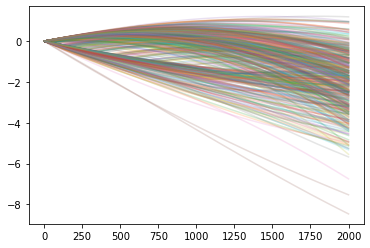

In [150]:
#work over time for the first 500 trials
plt.plot(all_W[:500,:].transpose(), alpha=.2);

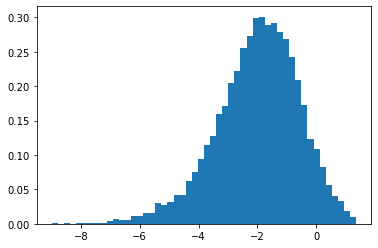

In [151]:
#just net work for all trials:
plt.hist(final_W, bins=50, density=True);

In [157]:
all_state.shape

(300, 2001, 1, 2)

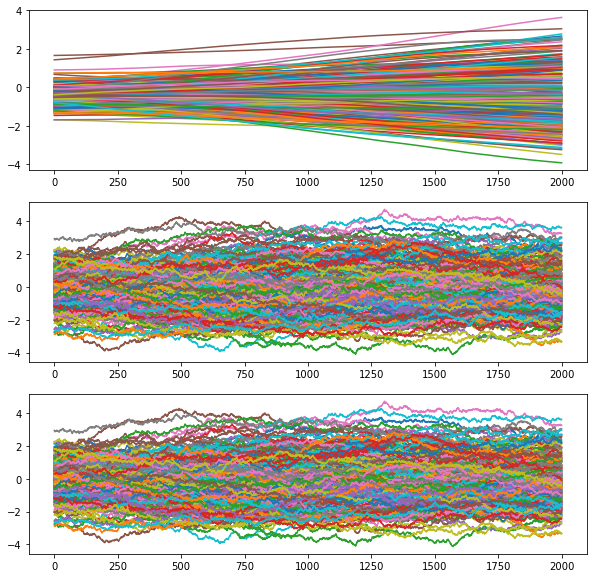

In [158]:
fig,ax = plt.subplots(3, figsize=(10,10))
#here are x,v and v_x plots over time
# [trial, step, position, phase]
ax[0].plot(all_state[:,:,0,0].transpose());
ax[1].plot(all_state[:,:,0,1].transpose());
ax[2].plot(all_state[:,:,0,1].transpose());


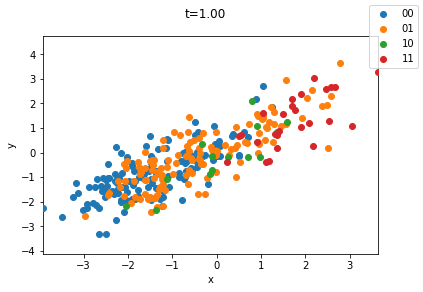

In [161]:
ani,_,_ = kt.animate_sim(all_state[:,:,0,:], frame_skip=100, color_by_state=True)
HTML(ani.to_jshtml(fps=30))

In [159]:
all_state.shape

(300, 2001, 1, 2)

# Simulation using 5D sphere potential

In [135]:
def five_d_sphere(x1, x2, x3, x4, x5, params):
    '''
    5D hard sphere 'well'
    
    Parameters
    ----------
    x1, x2, x3, x4, x5: ndarray of dimension [N_coords,]
        these are your coordinates
    params: list/tuple (1,2) [r, V0]:
        1: r, the radius of the sphere
        2: V0, the magnitude of the potential when you are inside the sphere
    
    Returns
    -------
    the value of the potential at the coordinates, for the params
    '''
    r, V0=params
    pos=x1, x2, x3, x4, x5
    distance=np.sqrt(np.sum(np.square(pos), axis=0))
    
    return  V0 * (1 - np.sign(distance - r)) / 2

def five_d_sphere_f(x1, x2, x3, x4, x5, params):
    '''
    See the five_d_sphere function, it has the same input format
    '''
    r,V0 = params
    pos = x1, x2, x3, x4, x5
    
    return(0, 0)

fds = Potential(five_d_sphere, five_d_sphere_f, 2, 5)

#then we make a Protocol
fds_times=(0,1)
fds_params=((.5,1.8),(-1,0))
fds_prot = Protocol(fds_times,fds_params)

#then use a System to apply fdp_prot to the fds potential
fds_sys=System(fds_prot,fds)

In [136]:
init_state = fds_sys.eq_state(10_000, 0, beta=1)

using a lower resolution for searching a space in >3 dimensions
new resolution is 20
 found 10012 samples out of 10000

In [141]:
gamma, theta, eta = 1, 1, 1

dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, fds_sys.get_external_force)

dynamic.mass = fds_sys.mass

integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

procedures = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=slice(0, 300)),
            rp.MeasureAllValue(rp.get_dW, 'all_W'), 
            rp.MeasureFinalValue(rp.get_dW, 'final_W')]

In [143]:
dt = .0005
nsteps = int(fds_sys.protocol.t_f/dt)
# and create a Simulation object
sim = Simulation(integrator.update_state, procedures, nsteps, dt, initial_state=init_state)

# and associate the system with it, for future reference
sim.system = fds_sys
sim.output = sim.run(verbose=True)

ValueError: operands could not be broadcast together with shapes (2,) (10000,5) 